In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation as animation
from scipy import integrate
from progressbar import progressbar as prbar        # (use pip/conda install progressbar2, or rewrite line 116.)
from copy import copy
import random

In [2]:
RABBIT = 0
FOX = 1

UP = 0
DOWN = 1
LEFT = 2
RIGHT = 3
STAY = 4

# initial number of rabbits and foxes
nrabbits = 1
nfoxes = 1

# size of the grid
gridxsize = 30
gridysize = 30

# energy of a freshly spawned rabbit/fox
rabben = 20
foxen = 20

# chance of a new fox/rabbit being spawned at a gridpoint on a step
rabbit_newborn_chance = 0.01
fox_newborn_chance = 0.005

# number of steps to simulate
steps = 10

In [3]:
class Animal(object):
    """
    Tracks the animal's position, energy, species (rabbit/fox) and state (live/dead).
    """

    def __init__(self, x0, y0, init_energy, species):
        self.x = x0
        self.y = y0
        self.energy = init_energy
        self.species = species
        self.isDead = False


    def interact(self, other):
        """
        Interact with another animal:
            - If they're from the same species, ignore each other.
            - Fox eats rabbit.
        """
        if self.species == RABBIT and other.species == FOX:
            self.die()

        elif self.species == FOX and other.species == RABBIT:
            other.die()



    def die(self):
        "R.I.P"
        self.isDead = True


    def move(self, direction):
        """Move a step on the grid. Each step consumes 1 energy; if no energy left, die.
        If hitting the bounds of the grid, "bounde back", step to the opposite direction insetad.

        Arguments:
            direction {int} -- direction to move: UP: 0, DOWN: 1, LEFT: 2, RIGHT: 3, STAY: 4
        """
        self.energy -= 1

        if direction == LEFT:
            self.x += 1 if self.x > 0 else -1   #"bounce back"
        if direction == RIGHT:
            self.x -= 1 if self.x < gridxsize-1 else -1
        if direction == UP:
            self.y += 1 if self.y < gridysize-1 else -1
        if direction == DOWN:
            self.y -= 1 if self.y > 0 else -1
        if direction == STAY:
            pass

        if self.energy <= 0:
            self.die()          #R.I.P.



In [4]:
import lhsmdu
import matplotlib.pyplot as plt
import numpy

In [5]:
##initialize with maximum values and 
class scen():
    def __init__(self):
        # initial number of rabbits and foxes
        self.nrabbits = 5 #1
        self.nfoxes = 5 #1

        # size of the grid
        self.gridxsize = 30
        self.gridysize = 30

        # energy of a freshly spawned rabbit/fox
        self.rabben = 10 #20
        self.foxen = 10 #20

        # chance of a new fox/rabbit being spawned at a gridpoint on a step
        self.rabbit_newborn_chance = 0.5 #0.01
        self.fox_newborn_chance = 0.5 #0.005

        # number of steps to simulate
        self.steps = 1000
        
    def applyScenParams(self, factors):
        self.origParams = [self.nrabbits, self.nfoxes, self.rabben, self.foxen, self.rabbit_newborn_chance, self.fox_newborn_chance]
                
        self.nrabbits = self.nrabbits * factors[0]
        self.nfoxes = self.nfoxes * factors[1]
        
        self.rabben = self.rabben * factors[2]
        self.foxen = self.foxen * factors[3]
        
        self.rabbit_newborn_chance = self.rabbit_newborn_chance * factors[4]
        self.fox_newborn_chance = self.fox_newborn_chance * factors[5]
        
    def applyRangeScenParams(self, minFact, maxFact):
        #self.origParams = [self.nrabbits, self.nfoxes, self.rabben, self.foxen, self.rabbit_newborn_chance, self.fox_newborn_chance]
        
        self.nrabbits = random.uniform(minFact[0], maxFact[0])
        self.nfoxes = random.uniform(minFact[1], maxFact[1])
        
        self.rabben = random.uniform(minFact[2], maxFact[2])
        self.foxen = random.uniform(minFact[3], maxFact[3])
        
        self.rabbit_newborn_chance = random.uniform(minFact[4], maxFact[4])
        self.fox_newborn_chance = random.uniform(minFact[5], maxFact[5])
    
    def get_x(self):
        x = [self.nrabbits, self.nfoxes, self.rabben, self.foxen, self.rabbit_newborn_chance, self.fox_newborn_chance]
        return x
        
    def record_y(self, nr, nf):
        self.rabbitnums = nr
        self.foxnums = nf
    
    def get_intersections(self):
        self.intersection = []
        keys = len(rabbitnums)        
        tmp_sr = 0
        for sr in range(0, keys):
            #print(scene_results['1_rab'][sr], scene_results['1_fox'][sr])
            if (sr != 0) and (tmp_sr == 0) and (self.foxnums[sr] > rabbitnums[sr]):
                tmp_sr = sr
                self.intersection.append(tmp_sr)
        return self.intersection
    
    def get_y(self):
        return self.rabbitnums, self.foxnums

In [6]:
scenes = []
samples = 100
for s in range(0,samples):
    tmp = scen()
    scenes.append(tmp)
print(len(scenes))

100


In [7]:
l = lhsmdu.sample(100,6) # Latin Hypercube Sampling of two variables, and 10 samples each.
l1 = lhsmdu.sample(6, 100)

In [8]:
l1[0]

matrix([[0.0453348 , 0.97596394, 0.31366028, 0.99807107, 0.16523286,
         0.66116748, 0.91129065, 0.48536859, 0.8793657 , 0.13308352,
         0.42869541, 0.72764096, 0.12247812, 0.29036341, 0.88101847,
         0.21728494, 0.4519967 , 0.57371271, 0.54501699, 0.30725468,
         0.63113231, 0.69406366, 0.08485073, 0.41540827, 0.50818361,
         0.84171678, 0.71807831, 0.98692878, 0.05555871, 0.56699528,
         0.25412018, 0.82138398, 0.01665765, 0.35524672, 0.76639375,
         0.95337999, 0.43906867, 0.1858737 , 0.22085402, 0.03449804,
         0.36756356, 0.46794135, 0.09494597, 0.51894748, 0.62267668,
         0.20410599, 0.96898597, 0.61896257, 0.93685713, 0.15858981,
         0.44088773, 0.37864995, 0.0032062 , 0.81178332, 0.7823937 ,
         0.33417969, 0.79251192, 0.89320568, 0.85134978, 0.32296177,
         0.55572284, 0.74441854, 0.77346719, 0.47746452, 0.8089351 ,
         0.64756789, 0.83332001, 0.92744442, 0.8615198 , 0.07130318,
         0.70345627, 0.02807702, 0

In [9]:
#t = np.array(l1[5])
t = l1[5].tolist()
t[0][1]

0.4520139910279389

In [10]:
print(len(l), len(scenes))
#l = l.tolist()
for i in range(0, len(scenes)):
    #print(i)
    tmp = []
    for j in l1:
        t = j.tolist()
        tmp.append(t[0][i])
    scenes[i].applyScenParams(tmp)
    
#l[0]   

100 100


In [11]:
countHigh = 0
for i in scenes:
    #if i.fox_newborn_chance > 0.01:
    if i.fox_newborn_chance > i.origParams[5]:
        countHigh = countHigh + 1
print(countHigh)

0


In [12]:
def scenario_test(s,scen_count):    
    scene_results = {}
    animals = []        # this will contain all animals on the grid
    
    # all possible coordinate pair (following https://stackoverflow.com/a/11144716/5099168)
    xcoords = np.arange(gridxsize)
    ycoords = np.arange(gridysize)
    coords = np.transpose([np.tile(xcoords, len(ycoords)), np.repeat(ycoords, len(xcoords))])

    # populate grid randomly, unique coordinates for all animals
    randcoords = np.random.permutation(coords)
    rabbitcoords = randcoords[:int(s.nrabbits)]
    foxcoords = randcoords[int(s.nrabbits):(int(s.nrabbits) + int(s.nfoxes))]

    for (x, y) in rabbitcoords:
        animals.append(Animal(x0=x, y0=y, init_energy=s.rabben, species=RABBIT))
    for (x, y) in foxcoords:
        animals.append(Animal(x0=x, y0=y, init_energy=s.foxen, species=FOX))


    t_rabcoordsx = []   # track the coordinates of the animals in each step in these arrays
    t_rabcoordsy = []
    t_foxcoordsx = []
    t_foxcoordsy = []

    rabbitnums, foxnums = [s.nrabbits], [s.nfoxes]  #track the number of rabbits and foxes too

    animfigs = []

    for i in prbar(range(steps), max_value = steps, redirect_stdout=True):          
        # NOTE: substitute with for i in range(steps) if progressbar2 is not installed
        # step with each animal in a random direction
        
        directions = np.random.randint(0, 5, size=len(animals))
        for animal, direction in zip(animals, directions):
            animal.move(direction)

        # generate newborn rabbits...
        rabbit_is_born_here = np.random.rand(len(coords)) <= s.rabbit_newborn_chance
        newrabbits = coords[rabbit_is_born_here]
        for (x, y) in newrabbits:
            animals.append(Animal(x0=x, y0=y, init_energy=s.rabben, species=RABBIT))

        #...  and foxes
        fox_is_born_here = np.random.rand(len(coords)) <= s.fox_newborn_chance
        newfoxes = coords[fox_is_born_here]
        for (x, y) in newfoxes:
            animals.append(Animal(x0=x, y0=y, init_energy=s.foxen, species=FOX))

        # interact if two animals are at the same coordinates
        for j, animal1 in enumerate(animals):
            for animal2 in animals[j:]:
                if (animal1.x == animal2.x and
                    animal1.y == animal2.y):
                    animal1.interact(animal2)

        # clean up corpses
        dead_indexes = []
        for j, animal in enumerate(animals):
            if animal.isDead:
                dead_indexes.append(j)
        animals = list(np.delete(animals, dead_indexes))

        # count animals and log
        foxnum, rabnum = 0,0
        for animal in animals:
            if animal.species == RABBIT:
                rabnum += 1
            elif animal.species == FOX:
                foxnum += 1
        rabbitnums.append(rabnum)
        foxnums.append(foxnum)
        # print(rabnum, foxnum, len(dead_indexes))

        # get and log animal coordinates
        rabcsx = []
        rabcsy = []
        foxcsx = []
        foxcsy = []
        for animal in animals:
            if animal.species == RABBIT:
                rabcsx.append(animal.x)
                rabcsy.append(animal.y)
                # ax.plot(, animal.y, 'bo')
            elif animal.species == FOX:
                foxcsx.append(animal.x)
                foxcsy.append(animal.y)
                # ax.plot(animal.x, animal.y, 'ro')

        t_rabcoordsx.append(rabcsx)
        t_rabcoordsy.append(rabcsy)
        t_foxcoordsx.append(foxcsx)
        t_foxcoordsy.append(foxcsy)
       
    s.record_y(rabbitnums, foxnums)
    scen_count = scen_count+1
    tmp_rab = str(scen_count)+'_rab'
    tmp_fox = str(scen_count)+'_fox'
    scene_results[tmp_rab] = rabbitnums
    scene_results[tmp_fox] = foxnums
    
    return scene_results

In [13]:
scene_results = {}
scen_count = 0
for s in scenes:
    print("current scenario ", str(scen_count))
    tmpScene = scenario_test(s, scen_count)
    for t in tmpScene.keys():
        scene_results[t] = tmpScene[t]
    scen_count = scen_count+1

current scenario  0


100% (10 of 10) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


current scenario  1


100% (10 of 10) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


current scenario  2


100% (10 of 10) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


current scenario  3


100% (10 of 10) |########################| Elapsed Time: 0:00:01 Time:  0:00:01


current scenario  4


100% (10 of 10) |########################| Elapsed Time: 0:00:01 Time:  0:00:01


current scenario  5


100% (10 of 10) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


current scenario  6


100% (10 of 10) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


current scenario  7


100% (10 of 10) |########################| Elapsed Time: 0:00:01 Time:  0:00:01


current scenario  8


100% (10 of 10) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


current scenario  9


100% (10 of 10) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


current scenario  10


100% (10 of 10) |########################| Elapsed Time: 0:00:01 Time:  0:00:01


current scenario  11


100% (10 of 10) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


current scenario  12


100% (10 of 10) |########################| Elapsed Time: 0:00:02 Time:  0:00:02


current scenario  13


100% (10 of 10) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


current scenario  14


100% (10 of 10) |########################| Elapsed Time: 0:00:01 Time:  0:00:01


current scenario  15


100% (10 of 10) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


current scenario  16


100% (10 of 10) |########################| Elapsed Time: 0:00:01 Time:  0:00:01


current scenario  17


100% (10 of 10) |########################| Elapsed Time: 0:00:01 Time:  0:00:01


current scenario  18


100% (10 of 10) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


current scenario  19


100% (10 of 10) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


current scenario  20


100% (10 of 10) |########################| Elapsed Time: 0:00:01 Time:  0:00:01


current scenario  21


100% (10 of 10) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


current scenario  22


100% (10 of 10) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


current scenario  23


100% (10 of 10) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


current scenario  24


100% (10 of 10) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


current scenario  25


100% (10 of 10) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


current scenario  26


100% (10 of 10) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


current scenario  27


100% (10 of 10) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


current scenario  28


100% (10 of 10) |########################| Elapsed Time: 0:00:01 Time:  0:00:01


current scenario  29


100% (10 of 10) |########################| Elapsed Time: 0:00:02 Time:  0:00:02


current scenario  30


100% (10 of 10) |########################| Elapsed Time: 0:00:01 Time:  0:00:01


current scenario  31


100% (10 of 10) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


current scenario  32


100% (10 of 10) |########################| Elapsed Time: 0:00:01 Time:  0:00:01


current scenario  33


100% (10 of 10) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


current scenario  34


100% (10 of 10) |########################| Elapsed Time: 0:00:01 Time:  0:00:01


current scenario  35


100% (10 of 10) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


current scenario  36


100% (10 of 10) |########################| Elapsed Time: 0:00:02 Time:  0:00:02


current scenario  37


100% (10 of 10) |########################| Elapsed Time: 0:00:01 Time:  0:00:01


current scenario  38


100% (10 of 10) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


current scenario  39


100% (10 of 10) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


current scenario  40


100% (10 of 10) |########################| Elapsed Time: 0:00:03 Time:  0:00:03


current scenario  41


100% (10 of 10) |########################| Elapsed Time: 0:00:01 Time:  0:00:01


current scenario  42


100% (10 of 10) |########################| Elapsed Time: 0:00:01 Time:  0:00:01


current scenario  43


100% (10 of 10) |########################| Elapsed Time: 0:00:01 Time:  0:00:01


current scenario  44


100% (10 of 10) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


current scenario  45


100% (10 of 10) |########################| Elapsed Time: 0:00:02 Time:  0:00:02


current scenario  46


100% (10 of 10) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


current scenario  47


100% (10 of 10) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


current scenario  48


100% (10 of 10) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


current scenario  49


100% (10 of 10) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


current scenario  50


100% (10 of 10) |########################| Elapsed Time: 0:00:02 Time:  0:00:02


current scenario  51


100% (10 of 10) |########################| Elapsed Time: 0:00:01 Time:  0:00:01


current scenario  52


100% (10 of 10) |########################| Elapsed Time: 0:00:01 Time:  0:00:01


current scenario  53


100% (10 of 10) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


current scenario  54


100% (10 of 10) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


current scenario  55


100% (10 of 10) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


current scenario  56


100% (10 of 10) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


current scenario  57


100% (10 of 10) |########################| Elapsed Time: 0:00:01 Time:  0:00:01


current scenario  58


100% (10 of 10) |########################| Elapsed Time: 0:00:01 Time:  0:00:01


current scenario  59


100% (10 of 10) |########################| Elapsed Time: 0:00:02 Time:  0:00:02


current scenario  60


100% (10 of 10) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


current scenario  61


100% (10 of 10) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


current scenario  62


100% (10 of 10) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


current scenario  63


100% (10 of 10) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


current scenario  64


100% (10 of 10) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


current scenario  65


100% (10 of 10) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


current scenario  66


100% (10 of 10) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


current scenario  67


100% (10 of 10) |########################| Elapsed Time: 0:00:01 Time:  0:00:01


current scenario  68


100% (10 of 10) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


current scenario  69


100% (10 of 10) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


current scenario  70


100% (10 of 10) |########################| Elapsed Time: 0:00:02 Time:  0:00:02


current scenario  71


100% (10 of 10) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


current scenario  72


100% (10 of 10) |########################| Elapsed Time: 0:00:02 Time:  0:00:02


current scenario  73


100% (10 of 10) |########################| Elapsed Time: 0:00:01 Time:  0:00:01


current scenario  74


100% (10 of 10) |########################| Elapsed Time: 0:00:01 Time:  0:00:01


current scenario  75


100% (10 of 10) |########################| Elapsed Time: 0:00:01 Time:  0:00:01


current scenario  76


100% (10 of 10) |########################| Elapsed Time: 0:00:02 Time:  0:00:02


current scenario  77


100% (10 of 10) |########################| Elapsed Time: 0:00:01 Time:  0:00:01


current scenario  78


100% (10 of 10) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


current scenario  79


100% (10 of 10) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


current scenario  80


100% (10 of 10) |########################| Elapsed Time: 0:00:01 Time:  0:00:01


current scenario  81


100% (10 of 10) |########################| Elapsed Time: 0:00:02 Time:  0:00:02


current scenario  82


100% (10 of 10) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


current scenario  83


100% (10 of 10) |########################| Elapsed Time: 0:00:02 Time:  0:00:02


current scenario  84


100% (10 of 10) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


current scenario  85


100% (10 of 10) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


current scenario  86


100% (10 of 10) |########################| Elapsed Time: 0:00:01 Time:  0:00:01


current scenario  87


100% (10 of 10) |########################| Elapsed Time: 0:00:01 Time:  0:00:01


current scenario  88


100% (10 of 10) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


current scenario  89


100% (10 of 10) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


current scenario  90


100% (10 of 10) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


current scenario  91


100% (10 of 10) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


current scenario  92


100% (10 of 10) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


current scenario  93


100% (10 of 10) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


current scenario  94


100% (10 of 10) |########################| Elapsed Time: 0:00:02 Time:  0:00:02


current scenario  95


100% (10 of 10) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


current scenario  96


100% (10 of 10) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


current scenario  97


100% (10 of 10) |########################| Elapsed Time: 0:00:01 Time:  0:00:01


current scenario  98


100% (10 of 10) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


current scenario  99


100% (10 of 10) |########################| Elapsed Time: 0:00:01 Time:  0:00:01


In [14]:
scene_results = {}
scen_count = 0
for s in scenes:
    print("current scenario ", str(scen_count))
    animals = []        # this will contain all animals on the grid
    
    # all possible coordinate pair (following https://stackoverflow.com/a/11144716/5099168)
    xcoords = np.arange(gridxsize)
    ycoords = np.arange(gridysize)
    coords = np.transpose([np.tile(xcoords, len(ycoords)), np.repeat(ycoords, len(xcoords))])

    # populate grid randomly, unique coordinates for all animals
    randcoords = np.random.permutation(coords)
    rabbitcoords = randcoords[:int(s.nrabbits)]
    foxcoords = randcoords[int(s.nrabbits):(int(s.nrabbits) + int(s.nfoxes))]

    for (x, y) in rabbitcoords:
        animals.append(Animal(x0=x, y0=y, init_energy=s.rabben, species=RABBIT))
    for (x, y) in foxcoords:
        animals.append(Animal(x0=x, y0=y, init_energy=s.foxen, species=FOX))


    t_rabcoordsx = []   # track the coordinates of the animals in each step in these arrays
    t_rabcoordsy = []
    t_foxcoordsx = []
    t_foxcoordsy = []

    rabbitnums, foxnums = [s.nrabbits], [s.nfoxes]  #track the number of rabbits and foxes too

    animfigs = []

    for i in prbar(range(steps), max_value = steps, redirect_stdout=True):          
        # NOTE: substitute with for i in range(steps) if progressbar2 is not installed
        # step with each animal in a random direction
        
        directions = np.random.randint(0, 5, size=len(animals))
        for animal, direction in zip(animals, directions):
            animal.move(direction)

        # generate newborn rabbits...
        rabbit_is_born_here = np.random.rand(len(coords)) <= s.rabbit_newborn_chance
        newrabbits = coords[rabbit_is_born_here]
        for (x, y) in newrabbits:
            animals.append(Animal(x0=x, y0=y, init_energy=s.rabben, species=RABBIT))

        #...  and foxes
        fox_is_born_here = np.random.rand(len(coords)) <= s.fox_newborn_chance
        newfoxes = coords[fox_is_born_here]
        for (x, y) in newfoxes:
            animals.append(Animal(x0=x, y0=y, init_energy=s.foxen, species=FOX))

        # interact if two animals are at the same coordinates
        for j, animal1 in enumerate(animals):
            for animal2 in animals[j:]:
                if (animal1.x == animal2.x and
                    animal1.y == animal2.y):
                    animal1.interact(animal2)

        # clean up corpses
        dead_indexes = []
        for j, animal in enumerate(animals):
            if animal.isDead:
                dead_indexes.append(j)
        animals = list(np.delete(animals, dead_indexes))

        # count animals and log
        foxnum, rabnum = 0,0
        for animal in animals:
            if animal.species == RABBIT:
                rabnum += 1
            elif animal.species == FOX:
                foxnum += 1
        rabbitnums.append(rabnum)
        foxnums.append(foxnum)
        # print(rabnum, foxnum, len(dead_indexes))

        # get and log animal coordinates
        rabcsx = []
        rabcsy = []
        foxcsx = []
        foxcsy = []
        for animal in animals:
            if animal.species == RABBIT:
                rabcsx.append(animal.x)
                rabcsy.append(animal.y)
                # ax.plot(, animal.y, 'bo')
            elif animal.species == FOX:
                foxcsx.append(animal.x)
                foxcsy.append(animal.y)
                # ax.plot(animal.x, animal.y, 'ro')

        t_rabcoordsx.append(rabcsx)
        t_rabcoordsy.append(rabcsy)
        t_foxcoordsx.append(foxcsx)
        t_foxcoordsy.append(foxcsy)
       
    s.record_y(rabbitnums, foxnums)
    scen_count = scen_count+1
    tmp_rab = str(scen_count)+'_rab'
    tmp_fox = str(scen_count)+'_fox'
    scene_results[tmp_rab] = rabbitnums
    scene_results[tmp_fox] = foxnums

current scenario  0


100% (10 of 10) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


current scenario  1


100% (10 of 10) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


current scenario  2


100% (10 of 10) |########################| Elapsed Time: 0:00:01 Time:  0:00:01


current scenario  3


100% (10 of 10) |########################| Elapsed Time: 0:00:02 Time:  0:00:02


current scenario  4


100% (10 of 10) |########################| Elapsed Time: 0:00:02 Time:  0:00:02


current scenario  5


100% (10 of 10) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


current scenario  6


100% (10 of 10) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


current scenario  7


100% (10 of 10) |########################| Elapsed Time: 0:00:02 Time:  0:00:02


current scenario  8


100% (10 of 10) |########################| Elapsed Time: 0:00:01 Time:  0:00:01


current scenario  9


100% (10 of 10) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


current scenario  10


100% (10 of 10) |########################| Elapsed Time: 0:00:02 Time:  0:00:02


current scenario  11


100% (10 of 10) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


current scenario  12


100% (10 of 10) |########################| Elapsed Time: 0:00:03 Time:  0:00:03


current scenario  13


100% (10 of 10) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


current scenario  14


100% (10 of 10) |########################| Elapsed Time: 0:00:01 Time:  0:00:01


current scenario  15


100% (10 of 10) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


current scenario  16


100% (10 of 10) |########################| Elapsed Time: 0:00:01 Time:  0:00:01


current scenario  17


100% (10 of 10) |########################| Elapsed Time: 0:00:01 Time:  0:00:01


current scenario  18


100% (10 of 10) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


current scenario  19


100% (10 of 10) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


current scenario  20


100% (10 of 10) |########################| Elapsed Time: 0:00:01 Time:  0:00:01


current scenario  21


100% (10 of 10) |########################| Elapsed Time: 0:00:01 Time:  0:00:01


current scenario  22


100% (10 of 10) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


current scenario  23


100% (10 of 10) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


current scenario  24


100% (10 of 10) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


current scenario  25


100% (10 of 10) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


current scenario  26


100% (10 of 10) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


current scenario  27


100% (10 of 10) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


current scenario  28


100% (10 of 10) |########################| Elapsed Time: 0:00:02 Time:  0:00:02


current scenario  29


100% (10 of 10) |########################| Elapsed Time: 0:00:03 Time:  0:00:03


current scenario  30


100% (10 of 10) |########################| Elapsed Time: 0:00:01 Time:  0:00:01


current scenario  31


100% (10 of 10) |########################| Elapsed Time: 0:00:01 Time:  0:00:01


current scenario  32


100% (10 of 10) |########################| Elapsed Time: 0:00:01 Time:  0:00:01


current scenario  33


100% (10 of 10) |########################| Elapsed Time: 0:00:01 Time:  0:00:01


current scenario  34


100% (10 of 10) |########################| Elapsed Time: 0:00:01 Time:  0:00:01


current scenario  35


100% (10 of 10) |########################| Elapsed Time: 0:00:01 Time:  0:00:01


current scenario  36


100% (10 of 10) |########################| Elapsed Time: 0:00:02 Time:  0:00:02


current scenario  37


100% (10 of 10) |########################| Elapsed Time: 0:00:01 Time:  0:00:01


current scenario  38


100% (10 of 10) |########################| Elapsed Time: 0:00:01 Time:  0:00:01


current scenario  39


100% (10 of 10) |########################| Elapsed Time: 0:00:01 Time:  0:00:01


current scenario  40


100% (10 of 10) |########################| Elapsed Time: 0:00:04 Time:  0:00:04


current scenario  41


100% (10 of 10) |########################| Elapsed Time: 0:00:01 Time:  0:00:01


current scenario  42


100% (10 of 10) |########################| Elapsed Time: 0:00:02 Time:  0:00:02


current scenario  43


100% (10 of 10) |########################| Elapsed Time: 0:00:01 Time:  0:00:01


current scenario  44


100% (10 of 10) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


current scenario  45


100% (10 of 10) |########################| Elapsed Time: 0:00:03 Time:  0:00:03


current scenario  46


100% (10 of 10) |########################| Elapsed Time: 0:00:01 Time:  0:00:01


current scenario  47


100% (10 of 10) |########################| Elapsed Time: 0:00:01 Time:  0:00:01


current scenario  48


100% (10 of 10) |########################| Elapsed Time: 0:00:01 Time:  0:00:01


current scenario  49


100% (10 of 10) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


current scenario  50


100% (10 of 10) |########################| Elapsed Time: 0:00:03 Time:  0:00:03


current scenario  51


100% (10 of 10) |########################| Elapsed Time: 0:00:03 Time:  0:00:03


current scenario  52


100% (10 of 10) |########################| Elapsed Time: 0:00:01 Time:  0:00:01


current scenario  53


100% (10 of 10) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


current scenario  54


100% (10 of 10) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


current scenario  55


100% (10 of 10) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


current scenario  56


100% (10 of 10) |########################| Elapsed Time: 0:00:01 Time:  0:00:01


current scenario  57


100% (10 of 10) |########################| Elapsed Time: 0:00:02 Time:  0:00:02


current scenario  58


100% (10 of 10) |########################| Elapsed Time: 0:00:01 Time:  0:00:01


current scenario  59


100% (10 of 10) |########################| Elapsed Time: 0:00:02 Time:  0:00:02


current scenario  60


100% (10 of 10) |########################| Elapsed Time: 0:00:01 Time:  0:00:01


current scenario  61


100% (10 of 10) |########################| Elapsed Time: 0:00:01 Time:  0:00:01


current scenario  62


100% (10 of 10) |########################| Elapsed Time: 0:00:01 Time:  0:00:01


current scenario  63


100% (10 of 10) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


current scenario  64


100% (10 of 10) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


current scenario  65


100% (10 of 10) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


current scenario  66


100% (10 of 10) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


current scenario  67


100% (10 of 10) |########################| Elapsed Time: 0:00:02 Time:  0:00:02


current scenario  68


100% (10 of 10) |########################| Elapsed Time: 0:00:01 Time:  0:00:01


current scenario  69


100% (10 of 10) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


current scenario  70


100% (10 of 10) |########################| Elapsed Time: 0:00:03 Time:  0:00:03


current scenario  71


100% (10 of 10) |########################| Elapsed Time: 0:00:01 Time:  0:00:01


current scenario  72


100% (10 of 10) |########################| Elapsed Time: 0:00:04 Time:  0:00:04


current scenario  73


100% (10 of 10) |########################| Elapsed Time: 0:00:02 Time:  0:00:02


current scenario  74


100% (10 of 10) |########################| Elapsed Time: 0:00:02 Time:  0:00:02


current scenario  75


100% (10 of 10) |########################| Elapsed Time: 0:00:01 Time:  0:00:01


current scenario  76


100% (10 of 10) |########################| Elapsed Time: 0:00:03 Time:  0:00:03


current scenario  77


100% (10 of 10) |########################| Elapsed Time: 0:00:01 Time:  0:00:01


current scenario  78


100% (10 of 10) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


current scenario  79


100% (10 of 10) |########################| Elapsed Time: 0:00:01 Time:  0:00:01


current scenario  80


100% (10 of 10) |########################| Elapsed Time: 0:00:01 Time:  0:00:01


current scenario  81


100% (10 of 10) |########################| Elapsed Time: 0:00:03 Time:  0:00:03


current scenario  82


100% (10 of 10) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


current scenario  83


100% (10 of 10) |########################| Elapsed Time: 0:00:03 Time:  0:00:03


current scenario  84


100% (10 of 10) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


current scenario  85


100% (10 of 10) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


current scenario  86


100% (10 of 10) |########################| Elapsed Time: 0:00:02 Time:  0:00:02


current scenario  87


100% (10 of 10) |########################| Elapsed Time: 0:00:01 Time:  0:00:01


current scenario  88


100% (10 of 10) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


current scenario  89


100% (10 of 10) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


current scenario  90


100% (10 of 10) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


current scenario  91


100% (10 of 10) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


current scenario  92


100% (10 of 10) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


current scenario  93


100% (10 of 10) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


current scenario  94


100% (10 of 10) |########################| Elapsed Time: 0:00:02 Time:  0:00:02


current scenario  95


100% (10 of 10) |########################| Elapsed Time: 0:00:01 Time:  0:00:01


current scenario  96


100% (10 of 10) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


current scenario  97


100% (10 of 10) |########################| Elapsed Time: 0:00:01 Time:  0:00:01


current scenario  98


100% (10 of 10) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


current scenario  99


100% (10 of 10) |########################| Elapsed Time: 0:00:01 Time:  0:00:01


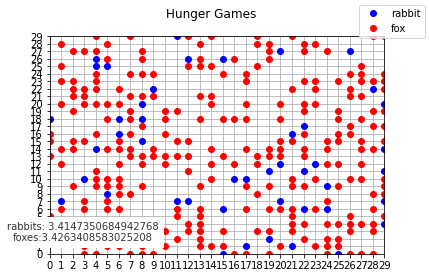

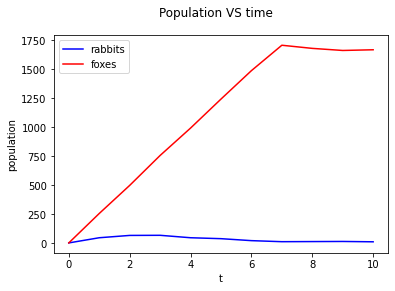

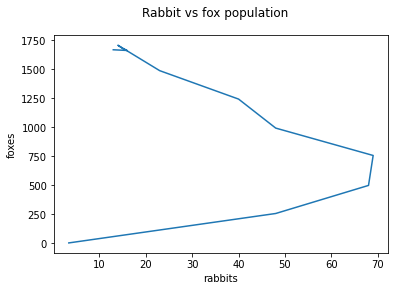

In [17]:
#Display the movement on an animation
fig, ax = plt.subplots()
fig.suptitle("Hunger Games")
ax.set_xlim(0, gridxsize-1)
ax.set_ylim(0, gridysize-1)
ax.set_xticks(xcoords)
ax.set_yticks(ycoords)
plt.grid(True)

rabpc, = ax.plot(t_rabcoordsx[0], t_rabcoordsy[0], 'bo', label='rabbit')
foxpc, = ax.plot(t_foxcoordsx[0], t_foxcoordsy[0], 'ro', label='fox')
fig.legend()

txt = ax.text(0.1, 0.1,'', ha='center', va='center', alpha=0.8,
              transform=ax.transAxes, fontdict={'color':'black', 'backgroundcolor': 'white', 'size': 10})

#initialize the animation:
def anim_init():
    rabpc.set_data(t_rabcoordsx[0], t_rabcoordsy[0])
    foxpc.set_data(t_foxcoordsx[0], t_foxcoordsy[0])
    txt.set_text('rabbits: {}\nfoxes:{}'.format(rabbitnums[0], foxnums[0]))
    return rabpc, foxpc, txt

#update the plot to the i-th frame:
def animate(i):
    rabpc.set_data(t_rabcoordsx[i], t_rabcoordsy[i])
    foxpc.set_data(t_foxcoordsx[i], t_foxcoordsy[i])
    txt.set_text('rabbits: {}\nfoxes:{}'.format(rabbitnums[i], foxnums[i]))
    return rabpc, foxpc, txt

#construct and display the animation
im_ani = animation.FuncAnimation(fig, animate, init_func=anim_init, frames=steps,
            interval=500, repeat=False, save_count=10, blit=True)
plt.show()


#plot population vs time
plt.plot(rabbitnums, 'b-', label="rabbits",)
plt.plot(foxnums, 'r-', label="foxes")
plt.xlabel('t')
plt.ylabel('population')
plt.suptitle("Population VS time")
plt.legend()
plt.show()

#plot rabbuts vs foxes
plt.suptitle("Rabbit vs fox population")
plt.plot(rabbitnums, foxnums)
plt.xlabel('rabbits')
plt.ylabel('foxes')
plt.show()

In [18]:
scene_results.keys()

dict_keys(['1_rab', '1_fox', '2_rab', '2_fox', '3_rab', '3_fox', '4_rab', '4_fox', '5_rab', '5_fox', '6_rab', '6_fox', '7_rab', '7_fox', '8_rab', '8_fox', '9_rab', '9_fox', '10_rab', '10_fox', '11_rab', '11_fox', '12_rab', '12_fox', '13_rab', '13_fox', '14_rab', '14_fox', '15_rab', '15_fox', '16_rab', '16_fox', '17_rab', '17_fox', '18_rab', '18_fox', '19_rab', '19_fox', '20_rab', '20_fox', '21_rab', '21_fox', '22_rab', '22_fox', '23_rab', '23_fox', '24_rab', '24_fox', '25_rab', '25_fox', '26_rab', '26_fox', '27_rab', '27_fox', '28_rab', '28_fox', '29_rab', '29_fox', '30_rab', '30_fox', '31_rab', '31_fox', '32_rab', '32_fox', '33_rab', '33_fox', '34_rab', '34_fox', '35_rab', '35_fox', '36_rab', '36_fox', '37_rab', '37_fox', '38_rab', '38_fox', '39_rab', '39_fox', '40_rab', '40_fox', '41_rab', '41_fox', '42_rab', '42_fox', '43_rab', '43_fox', '44_rab', '44_fox', '45_rab', '45_fox', '46_rab', '46_fox', '47_rab', '47_fox', '48_rab', '48_fox', '49_rab', '49_fox', '50_rab', '50_fox', '51_rab

In [19]:
intersection = []
keys = 100
for s in range(1, (keys+1)):    
    key_rab = str(s)+'_rab'
    key_fox = str(s)+'_fox'
    tmp_sr = 0
    for sr in range(0, len(scene_results[key_rab])):
        #print(scene_results['1_rab'][sr], scene_results['1_fox'][sr])
        if (sr != 0) and (tmp_sr == 0) and (scene_results[key_fox][sr] > scene_results[key_rab][sr]):
            tmp_sr = sr            
    intersection.append(tmp_sr)

#for sr in range(0, len(scene_results['5_rab'])):
#    print(scene_results['5_rab'][sr], scene_results['5_fox'][sr])    

In [20]:
intersection

[1,
 1,
 1,
 1,
 1,
 1,
 3,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 2,
 1,
 1,
 0,
 0,
 1,
 5,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 3,
 2,
 0,
 6,
 2,
 0,
 3,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 4,
 2,
 0,
 0,
 7,
 6,
 1,
 1,
 5,
 1,
 1,
 1,
 2,
 1,
 4,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 5,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 3,
 0,
 5,
 1,
 1]

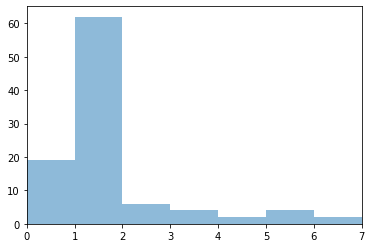

In [24]:
bins = np.arange(0,10, 1)
plt.xlim([min(intersection), max(intersection)])
plt.hist(intersection, bins=bins, alpha=0.5)
plt.show()

In [25]:
count = 0
data_list = []
for s in scenes:
    #print(s.get_x(), len(s.rabbitnums))    
    data_list.append([s.nrabbits, s.nfoxes, s.rabben, s.foxen, s.rabbit_newborn_chance, s.fox_newborn_chance])#, intersection[count]
    #count = count + 1

In [26]:
from __future__ import print_function

import prim
import pandas as pd
import matplotlib.pyplot as plt

# Create the pandas DataFrame
df = pd.DataFrame(data_list, columns=['x1', 'x2', 'x3', 'x4', 'x5', 'x6'])

In [27]:
df.head()

,x1,x2,x3,x4,x5,x6
0,0.226674,1.278561,0.605710,1.422972,0.165194,0.385046
1,4.879820,2.287270,0.311054,1.719957,0.090934,0.226007
2,1.568301,3.218948,7.521939,7.203778,0.214156,0.209795
3,4.990355,2.515138,0.746435,3.064337,0.203834,0.448067
4,0.826164,2.322967,9.243325,5.326251,0.456753,0.331308


In [28]:
p = prim.Prim(df, intersection, threshold=4, threshold_type=">")

In [29]:
df.head()

,x1,x2,x3,x4,x5,x6
0,0.226674,1.278561,0.605710,1.422972,0.165194,0.385046
1,4.879820,2.287270,0.311054,1.719957,0.090934,0.226007
2,1.568301,3.218948,7.521939,7.203778,0.214156,0.209795
3,4.990355,2.515138,0.746435,3.064337,0.203834,0.448067
4,0.826164,2.322967,9.243325,5.326251,0.456753,0.331308


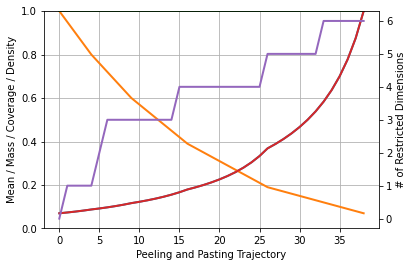

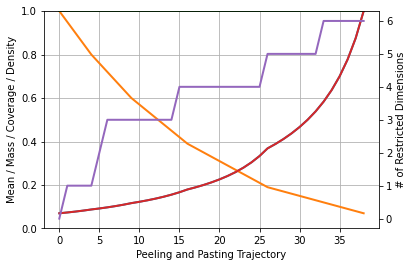

In [30]:
box = p.find_box()
box.show_ppt()


/home/pfoytik/predatorPrey/predatorPrey_senDisc/prim/prim_box.py:590: MatplotlibDeprecationWarning: 
The set_window_title function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use manager.set_window_title or GUI-specific methods instead.
  fig.canvas.set_window_title(title)


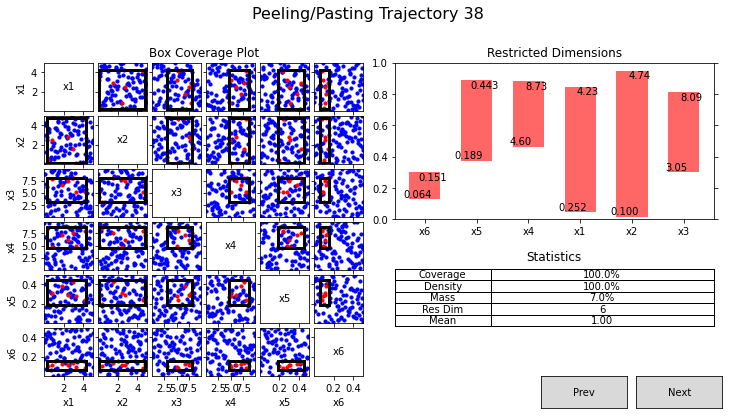

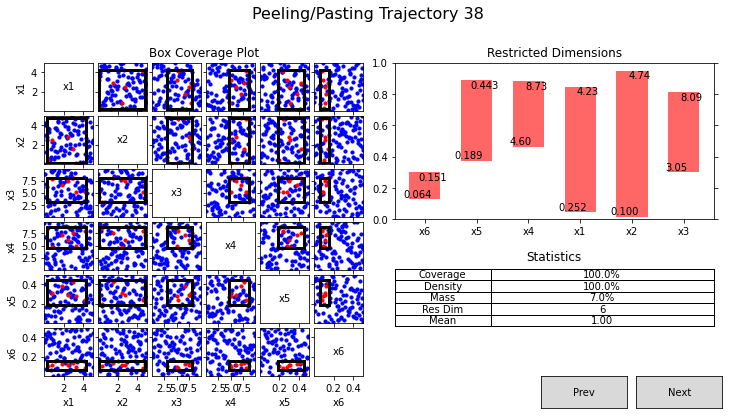

In [31]:
box.show_details()

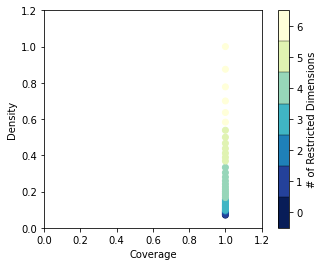

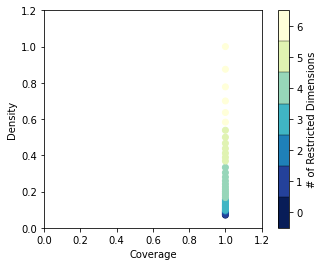

In [32]:
box.show_tradeoff()

In [33]:
box.select(32)

In [34]:
box._box_lims[0]

array([(0.016031  , 0.01521538, 0.06191214, 8.33790538e-03, 0.00402953, 0.0006554 ),
       (4.99035535, 4.99036308, 9.94263183, 9.91989298e+00, 0.49826997, 0.49790484)],
      dtype=[('x1', '<f8'), ('x2', '<f8'), ('x3', '<f8'), ('x4', '<f8'), ('x5', '<f8'), ('x6', '<f8')])

In [35]:
box._box_lims[32][1]

(4.23266642, 4.73789206, 8.08924735, 8.73497436, 0.44298568, 0.49790484)

In [36]:
box._box_lims[-1][1]

(4.23266642, 4.73789206, 8.08924735, 8.73497436, 0.44298568, 0.15076979)

In [37]:
for i in range(0, len(scenes)):
    scenes[i].applyRangeScenParams(box._box_lims[-1][0], box._box_lims[-1][1])
    


In [38]:
scene_results = {}
scen_count = 0
for s in scenes:
    print("current scenario ", str(scen_count))
    tmpScene = scenario_test(s, scen_count)
    for t in tmpScene.keys():
        scene_results[t] = tmpScene[t]
    scen_count = scen_count+1

current scenario  0


100% (10 of 10) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


current scenario  1


100% (10 of 10) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


current scenario  2


100% (10 of 10) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


current scenario  3


100% (10 of 10) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


current scenario  4


100% (10 of 10) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


current scenario  5


100% (10 of 10) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


current scenario  6


100% (10 of 10) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


current scenario  7


100% (10 of 10) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


current scenario  8


100% (10 of 10) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


current scenario  9


100% (10 of 10) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


current scenario  10


100% (10 of 10) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


current scenario  11


100% (10 of 10) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


current scenario  12


100% (10 of 10) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


current scenario  13


100% (10 of 10) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


current scenario  14


100% (10 of 10) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


current scenario  15


100% (10 of 10) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


current scenario  16


100% (10 of 10) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


current scenario  17


100% (10 of 10) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


current scenario  18


100% (10 of 10) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


current scenario  19


100% (10 of 10) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


current scenario  20


100% (10 of 10) |########################| Elapsed Time: 0:00:01 Time:  0:00:01


current scenario  21


100% (10 of 10) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


current scenario  22


100% (10 of 10) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


current scenario  23


100% (10 of 10) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


current scenario  24


100% (10 of 10) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


current scenario  25


100% (10 of 10) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


current scenario  26


100% (10 of 10) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


current scenario  27


100% (10 of 10) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


current scenario  28


100% (10 of 10) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


current scenario  29


100% (10 of 10) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


current scenario  30


100% (10 of 10) |########################| Elapsed Time: 0:00:01 Time:  0:00:01


current scenario  31


100% (10 of 10) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


current scenario  32


100% (10 of 10) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


current scenario  33


100% (10 of 10) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


current scenario  34


100% (10 of 10) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


current scenario  35


100% (10 of 10) |########################| Elapsed Time: 0:00:01 Time:  0:00:01


current scenario  36


100% (10 of 10) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


current scenario  37


100% (10 of 10) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


current scenario  38


100% (10 of 10) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


current scenario  39


100% (10 of 10) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


current scenario  40


100% (10 of 10) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


current scenario  41


100% (10 of 10) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


current scenario  42


100% (10 of 10) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


current scenario  43


100% (10 of 10) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


current scenario  44


100% (10 of 10) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


current scenario  45


100% (10 of 10) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


current scenario  46


100% (10 of 10) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


current scenario  47


100% (10 of 10) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


current scenario  48


100% (10 of 10) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


current scenario  49


100% (10 of 10) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


current scenario  50


100% (10 of 10) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


current scenario  51


100% (10 of 10) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


current scenario  52


100% (10 of 10) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


current scenario  53


100% (10 of 10) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


current scenario  54


100% (10 of 10) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


current scenario  55


100% (10 of 10) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


current scenario  56


100% (10 of 10) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


current scenario  57


100% (10 of 10) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


current scenario  58


100% (10 of 10) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


current scenario  59


100% (10 of 10) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


current scenario  60


100% (10 of 10) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


current scenario  61


100% (10 of 10) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


current scenario  62


100% (10 of 10) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


current scenario  63


100% (10 of 10) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


current scenario  64


100% (10 of 10) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


current scenario  65


100% (10 of 10) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


current scenario  66


100% (10 of 10) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


current scenario  67


100% (10 of 10) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


current scenario  68


100% (10 of 10) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


current scenario  69


100% (10 of 10) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


current scenario  70


100% (10 of 10) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


current scenario  71


100% (10 of 10) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


current scenario  72


100% (10 of 10) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


current scenario  73


100% (10 of 10) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


current scenario  74


100% (10 of 10) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


current scenario  75


100% (10 of 10) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


current scenario  76


100% (10 of 10) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


current scenario  77


100% (10 of 10) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


current scenario  78


100% (10 of 10) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


current scenario  79


100% (10 of 10) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


current scenario  80


100% (10 of 10) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


current scenario  81


100% (10 of 10) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


current scenario  82


100% (10 of 10) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


current scenario  83


100% (10 of 10) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


current scenario  84


100% (10 of 10) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


current scenario  85


100% (10 of 10) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


current scenario  86


100% (10 of 10) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


current scenario  87


100% (10 of 10) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


current scenario  88


100% (10 of 10) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


current scenario  89


100% (10 of 10) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


current scenario  90


100% (10 of 10) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


current scenario  91


100% (10 of 10) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


current scenario  92


100% (10 of 10) |########################| Elapsed Time: 0:00:01 Time:  0:00:01


current scenario  93


100% (10 of 10) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


current scenario  94


100% (10 of 10) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


current scenario  95


100% (10 of 10) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


current scenario  96


100% (10 of 10) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


current scenario  97


100% (10 of 10) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


current scenario  98


100% (10 of 10) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


current scenario  99


100% (10 of 10) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


In [39]:
intersection = []
keys = 100
for s in range(1, (keys+1)):    
    key_rab = str(s)+'_rab'
    key_fox = str(s)+'_fox'
    tmp_sr = 0
    for sr in range(0, len(scene_results[key_rab])):
        #print(scene_results['1_rab'][sr], scene_results['1_fox'][sr])
        if (sr != 0) and (tmp_sr == 0) and (scene_results[key_fox][sr] > scene_results[key_rab][sr]):
            tmp_sr = sr            
    intersection.append(tmp_sr)
    
#intersection
count = 0
data_list = []
for s in scenes:
    #print(s.get_x(), len(s.rabbitnums))    
    data_list.append([s.nrabbits, s.nfoxes, s.rabben, s.foxen, s.rabbit_newborn_chance, s.fox_newborn_chance])#, intersection[count]
    #count = count + 1

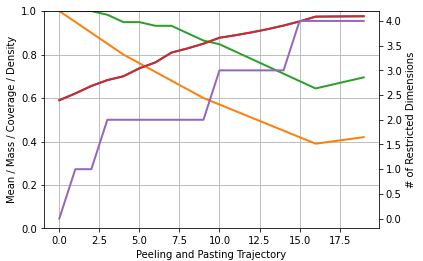

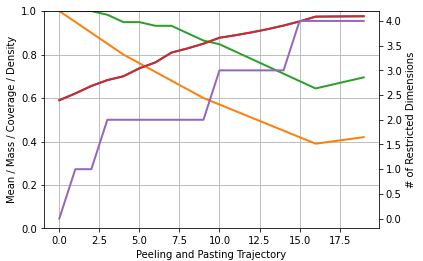

In [40]:
df = pd.DataFrame(data_list, columns=['x1', 'x2', 'x3', 'x4', 'x5', 'x6'])
p = prim.Prim(df, intersection, threshold=4, threshold_type=">")
box = p.find_box()
box.show_ppt()


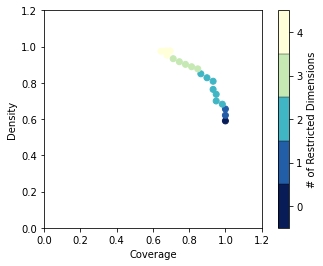

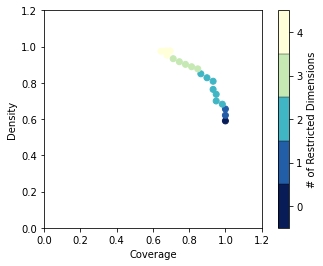

In [41]:
box.show_tradeoff()

/home/pfoytik/predatorPrey/predatorPrey_senDisc/prim/prim_box.py:590: MatplotlibDeprecationWarning: 
The set_window_title function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use manager.set_window_title or GUI-specific methods instead.
  fig.canvas.set_window_title(title)


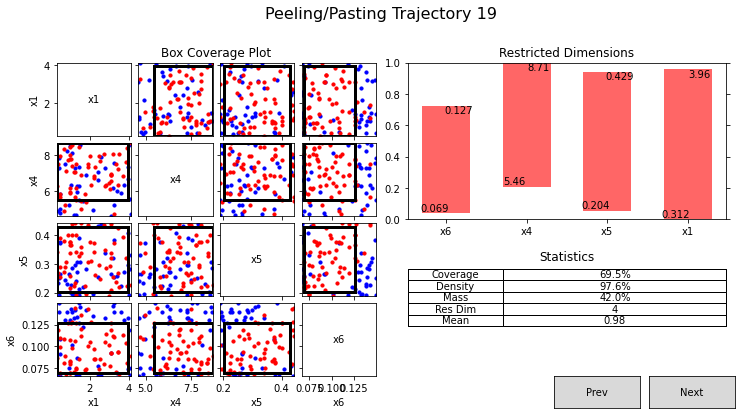

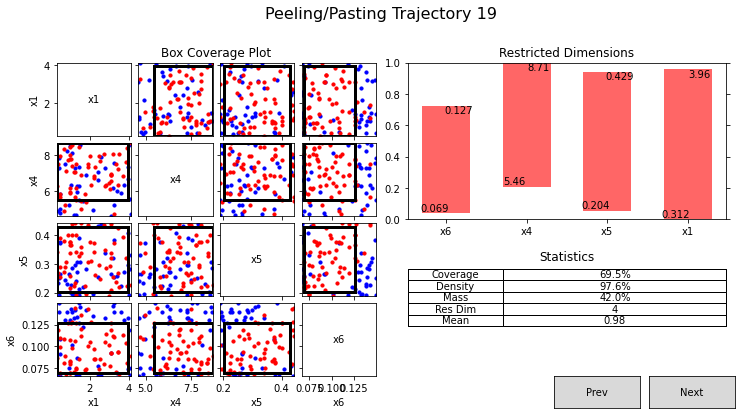

In [42]:
box.show_details()

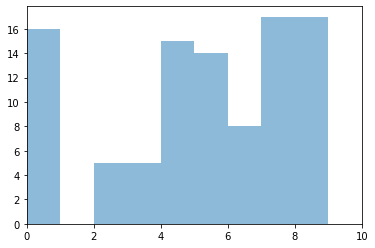

In [43]:
bins = np.arange(0,10, 1)
plt.xlim([min(intersection), max(intersection)])
plt.hist(intersection, bins=bins, alpha=0.5)
plt.show()